In [3]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.read_utils.read_gs_ply_files import convert_to_gaussian_schema, read_ply_file
from splat.utils import read_images_binary, read_images_text

# stem = "/Users/derek/Desktop/intro_to_gaussian_splatting"
stem = "/home/da2986/intro_to_gaussian_splatting"

# models_path = "/Users/derek/Downloads/models/"
models_path = "/home/da2986/intro_to_gaussian_splatting/models"
ply_path = f"/home/da2986/gaussian-splatting/truck/point_cloud/iteration_30000/point_cloud.ply"
vertices = read_ply_file(ply_path)
gaussians = convert_to_gaussian_schema(vertices[:5])

colmap_path = f"{stem}/data/treehill/sparse/0"
colmap_path = f"/home/da2986/gaussian-splatting/tandt/truck/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

Vertex Count: 2541226
Properties: [('float', 'x'), ('float', 'y'), ('float', 'z'), ('float', 'nx'), ('float', 'ny'), ('float', 'nz'), ('float', 'f_dc_0'), ('float', 'f_dc_1'), ('float', 'f_dc_2'), ('float', 'f_rest_0'), ('float', 'f_rest_1'), ('float', 'f_rest_2'), ('float', 'f_rest_3'), ('float', 'f_rest_4'), ('float', 'f_rest_5'), ('float', 'f_rest_6'), ('float', 'f_rest_7'), ('float', 'f_rest_8'), ('float', 'f_rest_9'), ('float', 'f_rest_10'), ('float', 'f_rest_11'), ('float', 'f_rest_12'), ('float', 'f_rest_13'), ('float', 'f_rest_14'), ('float', 'f_rest_15'), ('float', 'f_rest_16'), ('float', 'f_rest_17'), ('float', 'f_rest_18'), ('float', 'f_rest_19'), ('float', 'f_rest_20'), ('float', 'f_rest_21'), ('float', 'f_rest_22'), ('float', 'f_rest_23'), ('float', 'f_rest_24'), ('float', 'f_rest_25'), ('float', 'f_rest_26'), ('float', 'f_rest_27'), ('float', 'f_rest_28'), ('float', 'f_rest_29'), ('float', 'f_rest_30'), ('float', 'f_rest_31'), ('float', 'f_rest_32'), ('float', 'f_rest_33'

100%|██████████| 1000/1000 [00:00<00:00, 97099.36it/s]

[-0.37234583497047424, -0.41850927472114563, -0.25019344687461853]
tensor([0.3950, 0.3819, 0.4294])


In [10]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 2
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2] / 2
focal_x = int(focal_x)
focal_y = int(focal_y)
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width / 2
width = int(width)
height = camera_dict[image_dict[image_num].camera_id].height / 2
height = int(height)
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T

In [11]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
scene.device = "cpu"
TILE_SIZE = 16

In [12]:
processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    tile_size=TILE_SIZE
)

covariance_2d tensor([[[ 5.2790, -1.3900],
         [-1.3900,  0.7212]]])
mid tensor([3.0001])
det tensor([1.8751])
lambda1, lambda2 tensor([5.6695]) tensor([0.3307])
torch.Size([2, 5]) torch.Size([2, 5])


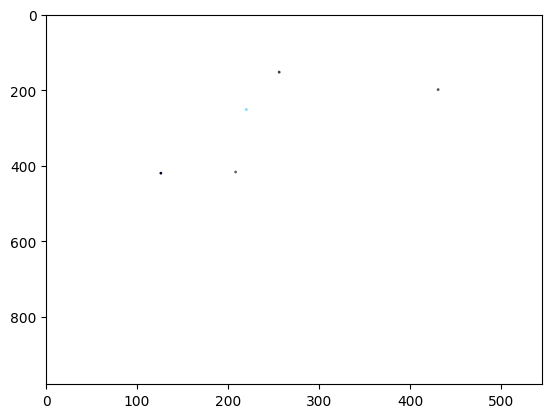

In [13]:
import matplotlib.pyplot as plt

plt.scatter(
    processed_gaussians.means_3d[:, 0].detach().cpu(),
    processed_gaussians.means_3d[:, 1].detach().cpu(),
    c=processed_gaussians.color.detach().cpu(),
    s=1,
)

plt.xlim(0, height)
plt.ylim(0, width)
plt.gca().invert_yaxis()
plt.show()

starting sum
ending sum


100%|██████████| 16/16 [00:00<00:00, 13135.42it/s]


156 31


100%|██████████| 16/16 [00:00<00:00, 10869.59it/s]


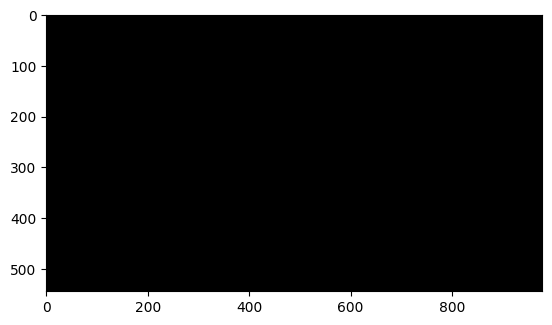

In [14]:
with torch.no_grad():
    output_image = scene.render(
        preprocessed_gaussians=processed_gaussians, height=height, width=width, tile_size=TILE_SIZE
    )

plt.imshow(output_image.cpu().numpy())
plt.show()

Found 0 non-zero pixels at coordinates:


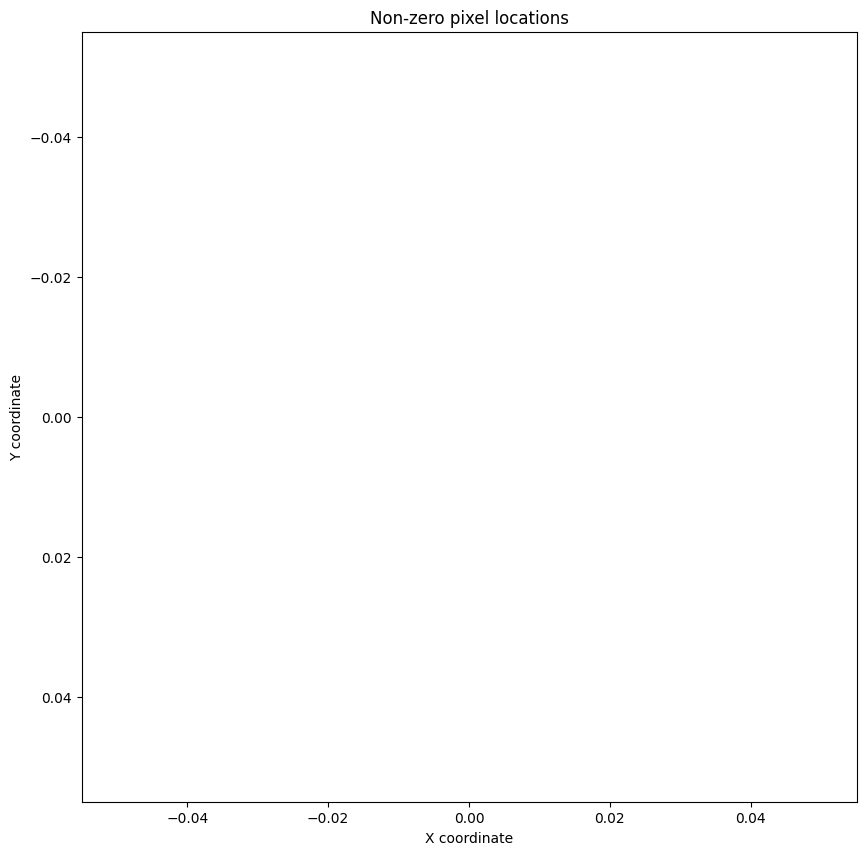

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Convert output image to numpy and find non-zero pixels
image_np = output_image.cpu().numpy()
nonzero_pixels = np.argwhere(image_np > 1e-3)

print(f"Found {len(nonzero_pixels)} non-zero pixels at coordinates:")
for y, x, c in nonzero_pixels:
    print(f"Position (y={y}, x={x}, channel={c}), Value={image_np[y,x,c]}")

# Optional visualization of non-zero pixel locations
plt.figure(figsize=(10,10))
plt.scatter(nonzero_pixels[:,1], nonzero_pixels[:,0], c='red', s=1, alpha=0.1)
plt.title("Non-zero pixel locations")
plt.xlabel("X coordinate") 
plt.ylabel("Y coordinate")
plt.gca().invert_yaxis() # Invert Y axis to match image coordinates
plt.show()
